In [2]:
!pip install gurobipy
from google.colab import files
uploaded = files.upload()

     |████████████████████████████████| 11.5 MB 5.1 MB/s 


Saving price_demand_data.csv to price_demand_data.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import gurobipy as gp
import seaborn as sns
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Regression: Demand ~ Price

In [4]:
# loading the dataset
data = pd.read_csv('price_demand_data.csv')
print(data.shape)
data.head()

(99, 2)


,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


Coefficients are 1924.7175435291088 -1367.7125241625981


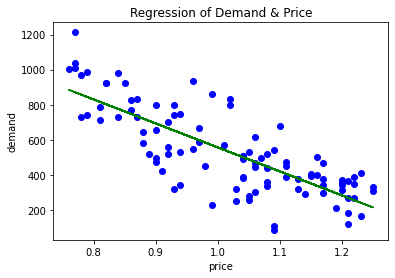

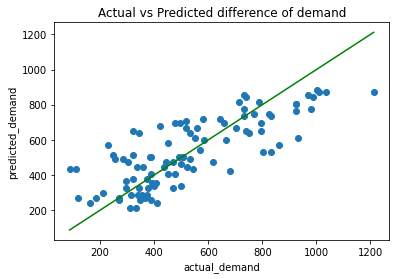

In [5]:
# fitting linear regression
lr = LinearRegression()
lr.fit(data[['price']], data['demand'])
beta0 = lr.intercept_
beta1 = lr.coef_[0]
print('Coefficients are', beta0, beta1)
data['predicted_demand'] = beta0 + beta1*data['price']

# plotting regression with demand
plt.figure()
plt.scatter(data['price'], data['demand'], color='blue')
plt.plot(data['price'], data['predicted_demand'], color='green')
plt.xlabel('price')
plt.ylabel('demand')
plt.title('Regression of Demand & Price')
plt.show()

# plotting the regression line
plt.figure()
plt.scatter(data['demand'], data['predicted_demand'])
plt.xlabel('actual_demand')
plt.ylabel('predicted_demand')

line = np.arange(data['demand'].min(), data['demand'].max())
plt.plot(line, line, color='green')
plt.title('Actual vs Predicted difference of demand')

plt.show()

In [6]:
# calculating residuals
new_data = pd.DataFrame()
new_data['residuals'] = data['demand'] - data['predicted_demand']

# creating demand with price = 1
p = 1
new_data['price'] = p
new_data['demand'] = beta0 + beta1*new_data['price'] + new_data['residuals']

# Newsvendor - Fixed Price

In [7]:
n = len(new_data)

# cost variables
c = 0.5
g = 0.75
t = 0.15

In [8]:
# init A, b, sense
A = np.zeros((n*2, n+1))
b = np.zeros(A.shape[0])
sense = ['<']*A.shape[0]
obj = np.zeros(A.shape[1])

# checking constraint matrix size
print('Shape of constraint matrix', A.shape)
print('Shape of b', b.shape)

# bounds
lb = [0] + [-np.inf]*n
ub = [np.inf] + list((p+t)*new_data['demand'].values)

# obj[0] = -c/n
obj[1:] = 1/n

# decision variables - q, h1, h2, ....h99
for i in range(n):
    d = new_data.loc[i ,'demand']
    
    A[i, [0, i+1]] = [c-g, 1]
    b[i] = p*d - g*d
    
    A[n+i, [0, i+1]] = [c+t, 1]
    b[n+i] = p*d + t*d

Shape of constraint matrix (198, 100)
Shape of b (198,)


In [9]:
# creating gurobi model with constraints
fixed_price_nv = gp.Model()
fixed_price_nv_x = fixed_price_nv.addMVar(len(obj),lb=lb, ub=ub)

fixed_price_nv_con = fixed_price_nv.addMConstrs(A, fixed_price_nv_x, sense, b) 
fixed_price_nv.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

fixed_price_nv.Params.OutputFlag = 0 # 
fixed_price_nv.optimize()

Restricted license - for non-production use only - expires 2023-10-25


In [10]:
# profit and optimal quantity for fixed price model
q = fixed_price_nv.x[0]
exp_profit = fixed_price_nv.objVal

print('Optimal Quantity is ', q)
print('Expected profit is ', exp_profit)

Optimal Quantity is  471.8653795908935
Expected profit is  231.4836666471413


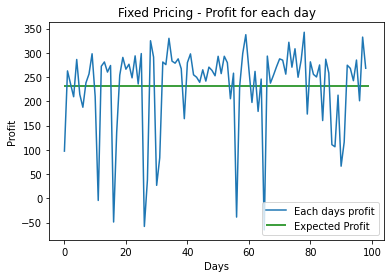

In [11]:
new_data['quantity'] = q
new_data['profit'] = np.where(
    new_data['demand'] > q,
    p*new_data['demand'] - g*new_data['demand'] - (c-g)*q,
    p*new_data['demand'] + t*new_data['demand'] - (c+t)*q)

plt.figure()
plt.title('Fixed Pricing - Profit for each day')
plt.xlabel('Days')
plt.ylabel('Profit')
plt.plot(new_data['profit'])
plt.hlines(exp_profit, 0, 99, color='green')
plt.legend(['Each days profit', 'Expected Profit'])
plt.show()

# Newsvendor - Price unknown

In [12]:
def profit_opt_price_unknown(residuals, beta0, beta1):
    n = len(residuals)
    # init A, b, sense
    # decision variables - [q, p, h1, h2, ... h99]
    A = np.zeros((n*2, n+2))
    b = np.zeros(A.shape[0])
    sense = ['<']*A.shape[0]
    obj = np.zeros(A.shape[1])
    Q = np.zeros((A.shape[1], A.shape[1]))

    # bounds
    lb = [0] + [0] + [-np.inf]*n
    ub = [np.inf] + [np.inf] + [np.inf]*n

    obj[1] = beta0 + np.mean(residuals)
    obj[2:] = 1/n

    Q[1, 1] = beta1

    for i in range(n):
        eps = residuals[i]

        A[i, [0, 1, i+2]] = [c-g,  g*beta1, 1]
        b[i] = -g*beta0 - g*eps 

        A[n+i, [0, 1, i+2]] = [c+t, -t*beta1, 1]
        b[n+i] = t*beta0 + t*eps
    
    model = gp.Model()
    model_x = model.addMVar(len(obj),lb=lb, ub=ub)

    model_con = model.addMConstr(A, model_x, sense, b) 
    model.setMObjective(Q,obj,0,sense=gp.GRB.MAXIMIZE)

    model.Params.OutputFlag = 0 # 
    model.optimize()
    
    return model

In [13]:
residuals = new_data['residuals'].values

In [14]:
dynamic_price_nv = profit_opt_price_unknown(residuals, beta0, beta1)

In [15]:
optimal_quantity, optimal_price = np.round(dynamic_price_nv.x[0], 2), np.round(dynamic_price_nv.x[1], 2)
print('Optimal quantity is', optimal_quantity, 'Optimal price is', optimal_price)

Optimal quantity is 535.29 Optimal price is 0.95


In [16]:
expected_profit = np.round(dynamic_price_nv.objVal, 2)
print('Expected Profit is', expected_profit)

Expected Profit is 234.42


In [17]:
beta0, beta1, residuals.shape

(1924.7175435291088, -1367.7125241625981, (99,))

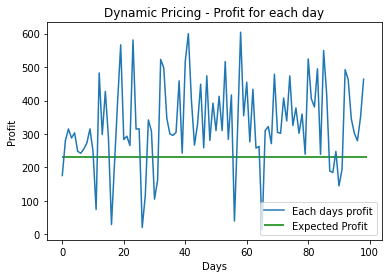

In [18]:
data_d = data.copy()
# creating demand as a function of optimal price
# calculating the profit based on the formula give in the problem statement
data_d['quantity'] = optimal_quantity
data_d['price'] = optimal_price
data_d['opt_demand'] = beta0 + beta1*optimal_price + residuals
data_d['profit'] = np.where(
    data_d['demand'] > optimal_quantity,
    p*data_d['opt_demand'] - g*data_d['opt_demand'] - (c-g)*q,
    p*data_d['opt_demand'] + t*data_d['opt_demand'] - (c+t)*q)

plt.figure()
plt.title('Dynamic Pricing - Profit for each day')
plt.xlabel('Days')
plt.ylabel('Profit')
plt.plot(data_d['profit'])
plt.hlines(exp_profit, 0, 99, color='green')
plt.legend(['Each days profit', 'Expected Profit'])
plt.show()

# Price sensitivity - Bootstrapping

In [19]:
def lr_output(data):
    lr = LinearRegression()
    lr.fit(data[['price']], data['demand'])
    beta0 = lr.intercept_
    beta1 = lr.coef_[0]

    pred = beta0 + beta1*data['price']
    
    res = (data['demand'] - pred).values
    
    return res, beta0, beta1

In [20]:
boot_sample = n
boot_n = 10000

quantity = []
price = []
profit = []

print(boot_sample)

for i in range(boot_n):
    idx = np.random.choice(np.arange(len(data)), size=boot_sample)
    data_sub = data.iloc[idx]
    residuals, beta0, beta1 = lr_output(data_sub)
    
    boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
    
    quantity.append(boot_model.x[0])
    price.append(boot_model.x[1])
    profit.append(boot_model.objVal)
    
output_df = pd.DataFrame({'profit': profit, 'price': price, 'quantity': quantity})

99


<Figure size 432x288 with 0 Axes>

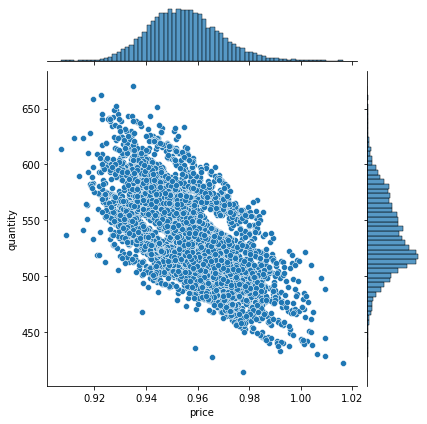

In [21]:
plt.figure()
sns.jointplot(x='price', y='quantity', data=output_df)
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

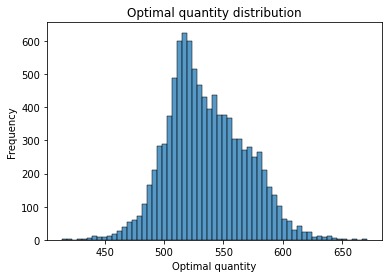

In [22]:
plt.figure()
sns.histplot(output_df['quantity'])
plt.xlabel('Optimal quantity')
plt.ylabel('Frequency')
plt.title('Optimal quantity distribution')
plt.show()

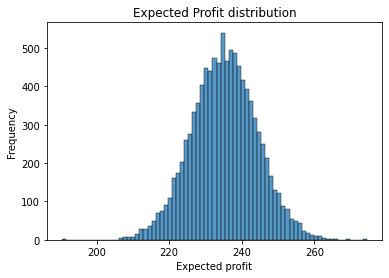

In [23]:
plt.figure()
sns.histplot(output_df['profit'])
plt.xlabel('Expected profit')
plt.ylabel('Frequency')
plt.title('Expected Profit distribution')
plt.show()

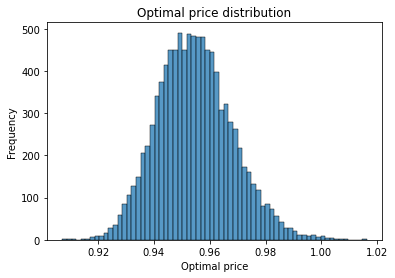

In [24]:
plt.figure()
sns.histplot(output_df['price'])
plt.xlabel('Optimal price')
plt.ylabel('Frequency')
plt.title('Optimal price distribution')
plt.show()

# Comparison with standard Newsvendor model

Standard newsvendor model - Demand to be considered same as the historical demand with fixed price of $1 

In [25]:
# decision variables are (q, h1, h2, ..., h99)
obj = np.zeros(n+1)
obj[1:] = 1.0/n
lb = np.zeros(n+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative
rhs = np.zeros(2*n)
direction = np.array(['<']*(2*n))

A = np.zeros((2*n, n+1))
for r in range(n):
    A[2*r,[0,r+1]] = [c,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = p*new_data.demand[r]
    A[2*r+1,[0,r+1]] = [c-p,1]
    rhs[2*r+1] = 0

baseline = gp.Model()
baseline_x = baseline.addMVar(len(obj),lb=lb) 
baseline_con = baseline.addMConstr(A, baseline_x, direction, rhs) 
baseline.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

baseline.Params.OutputFlag = 0 # tell gurobi to shut up!!
baseline.optimize()


In [26]:
baseline_quantity = baseline.x[0]
baseline_profit = baseline.objVal
print('Optimal quantity', baseline_quantity, 'Optimal profit', baseline_profit)

Optimal quantity 569.8967553157715 Optimal profit 219.28316552851416


In [27]:
# comparision of baseline profit with the distribution of dynamic pricing approach
# 95% confidence interval for dynamic priceing approach

# low = 0.025
# high = 0.975
low = 0.05
high = 0.95

low_q, high_q = np.quantile(output_df['quantity'], [low, high])
low_profit, high_profit = np.quantile(output_df['profit'], [low, high])
low_c, high_c = np.quantile(output_df['price'], [low, high])

if (baseline_profit < low_profit):
  print('Baseline NV approach gives statistically low profit')
elif (baseline_profit > high_profit):
  print('Baseline NV approach gives statistically High profit')
else:
  print('Fail to asset any significant difference in profit between baseline NV and Dynamic price approach')

if (baseline_quantity < low_q):
  print('Baseline NV approach gives statistically low quantity')
elif (baseline_quantity > high_q):
  print('Baseline NV approach gives statistically High quantity')
else:
  print('Fail to asset any significant difference in quantity between baseline NV and Dynamic price approach')

if (p < low_c):
  print('Baseline NV approach sell at low price statistically')
elif (p > high_c):
  print('Baseline NV approach sell at high price statistically')
else:
  print('Fail to asset any significant difference in price between baseline NV and Dynamic price approach')

Baseline NV approach gives statistically low profit
Fail to asset any significant difference in quantity between baseline NV and Dynamic price approach
Baseline NV approach sell at high price statistically


### With Dynamic pricing approach we are getting both higher profit and producing higher quantity, even though we charge less price to our customers

In [28]:
print('Profit')
print('Baseline', round(baseline_profit, 2))
print('Dynamic Price', round(np.mean(output_df['profit']), 2), round(low_profit, 2), round(high_profit, 2))
print('')
print('Price')
print('Baseline', round(1, 2))
print('Dynamic Price', round(np.mean(output_df['price']), 2), round(low_c, 3), round(high_c, 3))
print('')
print('Quantity')
print('Baseline', round(baseline_quantity, 2))
print('Dynamic Quantity', round(np.mean(output_df['quantity']), 2), round(low_q, 3), round(high_q, 3))

Profit
Baseline 219.28
Dynamic Price 235.2 220.58 249.98

Price
Baseline 1
Dynamic Price 0.95 0.934 0.978

Quantity
Baseline 569.9
Dynamic Quantity 535.7 487.612 591.757


In [29]:
print('Price')
print('Baseline', p)
print('Dynamic Price', np.mean(output_df['price']), low_c, high_c)

Price
Baseline 1
Dynamic Price 0.954753890488707 0.9337329734839991 0.9780701079927971


In [30]:
print(np.quantile(output_df['quantity'], [0.05, 0.95]))
print(np.quantile(output_df['profit'], [0.05, 0.95]))
print(np.quantile(output_df['price'], [0.05, 0.95]))

[487.61181308 591.75671221]
[220.57740835 249.97703624]
[0.93373297 0.97807011]
